# Link prediction example: GraphSAGE on the Cora citation dataset

In this example, we build a model to predict citation links in the PubMed-Diabetes dataset. The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a GraphSAGE model that takes pairs of papers as (paper1, paper2) corresponding to possible citation links, and outputs a pair of node embeddings each paper in the pair. These embeddings are then fed into a link classification layer, which applies a binary operator to those node embeddings (e.g., multiplying them elementwise) to construct the link embedding of the (paper1, paper2) pair. Next a dense layer with sigmoid activation function is used to obtain the prediction for these candidate links to actually exist in the network.

The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy) using stochastic gradient descent (SGD) updates of the model parameters using the 'training' node pairs fed into the model.

**References**

[1] Inductive Representation Learning on Large Graphs, W. L. Hamilton, R. Ying, and J. Leskovec, NIPS 2017

Copyright © 2010-2019 Commonwealth Scientific and Industrial Research Organisation (CSIRO). All Rights Reserved.

In [1]:
import networkx as nx
import pandas as pd
import os
import keras 
import numpy as np
import stellargraph as sg
import seaborn as sns
import sklearn
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.


In [2]:
sns.set(color_codes=True)

### Loading the CORA network data

### Dataset


The dataset is the citation network Cora. The following is the description of the dataset from the publisher:

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

The dataset can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`../data/cora/`

where the files `cora.cites` and `cora.content` can be located.

In [3]:
data_dir = os.path.expanduser("../data/cora")

Load the edgelist from the `.cites` file

In [4]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["source", "target"])

Next we create a networkx object from this edgelist:

In [5]:
g_nx = nx.from_pandas_edgelist(edgelist)

The node features and subject are in a seperate file. We load this using pandas:

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

The node features are the numeric features, not including the subject:

In [7]:
node_features = node_data[feature_names]

### Creating test/train pairs

We need to prepare a set of links for training and testing the model. To do this we are going to remove some edges from our input graph that we will use as *positive pairs* and in addition we generate some node pairs that are not in the graph randomly that we will use as *negative pairs*.  These pairs are split into train and test sets.

We will train and test the link prediction model using a reduced graph that has the same nodes as the input graph, but with the positive links removed.

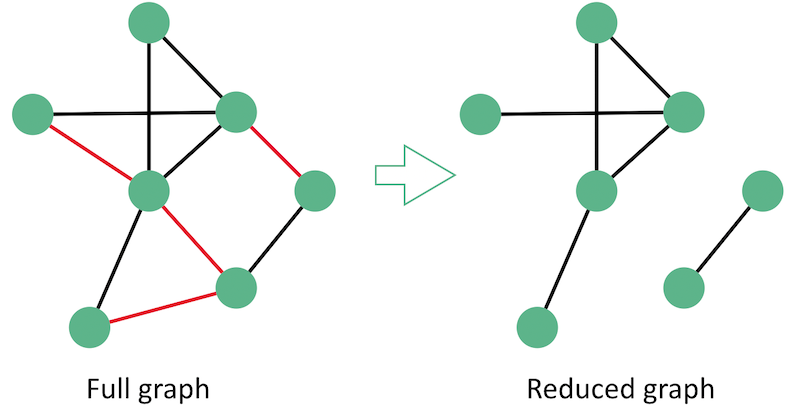

Shuffle the edgelist:

In [8]:
edgelist = np.random.permutation(edgelist)

Select 1000 edges as positive pairs. Note that this will likely make the graph disconnected. This is not an issue for the GraphSAGE algorithm, but can make other algorithms (such as node2vec) not work correctly. See "Alternative Edge Splitting" below for a way to split edges leaving the graph connected.

In [9]:
n_positive_pairs = n_negative_pairs = 1000

In [10]:
positive_pairs = edgelist[:n_positive_pairs]
remaining_links = edgelist[n_positive_pairs:]

Randomly choose the same number of negative links:

In [11]:
all_nodes = list(node_data.index)
negative_pairs = np.vstack([np.random.choice(all_nodes, size=n_negative_pairs),
                            np.random.choice(all_nodes, size=n_negative_pairs)]).T

In [12]:
all_pairs = np.vstack([positive_pairs, negative_pairs])
all_labels = np.hstack([np.ones(positive_pairs.shape[0]), np.zeros(negative_pairs.shape[0])])

Create training & test sets of edges from the positive and negative links:

In [13]:
train_pairs, test_pairs, train_labels, test_labels = model_selection.train_test_split(
    all_pairs, all_labels, train_size=0.5, random_state=42
)

### Creating the link prediction model

Let's create a graph from the remaining edges with the positive pairs removed, but including all nodes:

In [14]:
g_reduced = nx.Graph()
g_reduced.add_nodes_from(all_nodes)
g_reduced.add_edges_from(remaining_links)

Now create a StellarGraph object from the NetworkX graph and the node features and targets. This StellarGraph object is required to perform machine learning tasks on the graph.

In [15]:
G = sg.StellarGraph(g_reduced, node_features=node_features)

Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes (paper1, paper2) to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with (paper1, paper2) head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [16]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [17]:
num_samples = [10, 10]

In [18]:
link_generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = link_generator.flow(train_pairs, train_labels)
test_gen = link_generator.flow(test_pairs, test_labels)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated (paper1, paper2) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 16 for both GraphSAGE layers. To help the model generalize we use dropout of 0.3. Note that the length of layer_sizes list must be equal to the length of num_samples.

In [19]:
graphsage = GraphSAGE(
        layer_sizes=[16, 16], generator=train_gen, dropout=0.3
    )

In [20]:
x_inp, x_out = graphsage.link_model()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



The link classification layer takes a pair of node embeddings and applies a binary operator to them to produce the corresponding link embedding ('mul' is the elementwise multiplication ; other options for the binary operator can be seen by running a cell with `?link_classification` in it)

In [21]:
h_link = link_classification(
        output_dim=1, output_act="linear", edge_embedding_method='mul'
    )(x_out)

link_classification: using 'mul' method to combine node embeddings into edge embeddings


The classification layer is a Keras dense layer with sigmoid activation:

In [22]:
prediction = keras.layers.Dense(1, activation='sigmoid')(h_link)

Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [23]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Evaluate the initial (untrained) model on the train and test set:

In [24]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.6922
	acc: 0.5190

Test Set Metrics of the initial (untrained) model:
	loss: 0.6956
	acc: 0.5160


Now we train the model using the training generator to feed the features for the node pairs:

In [25]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2
    )

Epoch 1/20
 - 9s - loss: 0.6939 - acc: 0.5310 - val_loss: 0.6892 - val_acc: 0.5520
Epoch 2/20
 - 8s - loss: 0.6741 - acc: 0.6030 - val_loss: 0.6829 - val_acc: 0.5700
Epoch 3/20
 - 8s - loss: 0.6528 - acc: 0.6890 - val_loss: 0.6787 - val_acc: 0.5660
Epoch 4/20
 - 8s - loss: 0.6353 - acc: 0.7180 - val_loss: 0.6715 - val_acc: 0.6050
Epoch 5/20
 - 10s - loss: 0.6021 - acc: 0.7920 - val_loss: 0.6619 - val_acc: 0.6130
Epoch 6/20
 - 9s - loss: 0.5737 - acc: 0.8350 - val_loss: 0.6624 - val_acc: 0.5940
Epoch 7/20
 - 8s - loss: 0.5391 - acc: 0.8490 - val_loss: 0.6502 - val_acc: 0.6270
Epoch 8/20
 - 8s - loss: 0.5030 - acc: 0.8610 - val_loss: 0.6401 - val_acc: 0.6280
Epoch 9/20
 - 9s - loss: 0.4627 - acc: 0.8960 - val_loss: 0.6352 - val_acc: 0.6220
Epoch 10/20
 - 9s - loss: 0.4218 - acc: 0.9170 - val_loss: 0.6335 - val_acc: 0.6340
Epoch 11/20
 - 8s - loss: 0.3818 - acc: 0.9200 - val_loss: 0.6461 - val_acc: 0.6250
Epoch 12/20
 - 8s - loss: 0.3419 - acc: 0.9340 - val_loss: 0.6388 - val_acc: 0.6440


Plot the training history:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

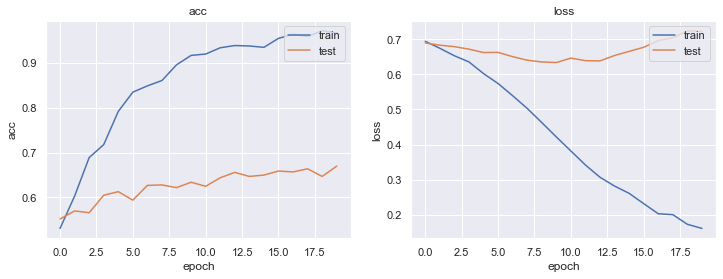

In [27]:
plot_history(history)

Evaluate the trained model on test citation links:

In [28]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.0984
	acc: 0.9950

Test Set Metrics of the trained model:
	loss: 0.7246
	acc: 0.6690


We get good results here, but let's look a the graph distances between the nodes in the positive pairs and the negative pairs.

In [29]:
def pair_distance(G, pairs, ignore_disconnected=True):
    pair_distance = []
    for n1,n2 in pairs:
        try:
            l = nx.shortest_path_length(G, n1, n2)
        except:
            l = -1
        if not ignore_disconnected or l >= 0:
            pair_distance.append(l)
    return pair_distance

In [30]:
pp_distance = pair_distance(g_reduced, positive_pairs)
np_distance = pair_distance(g_reduced, negative_pairs)

Note that the distribution of shortest-path lengths for the positive and negative pairs are different. This can make the problem of separating positive and negative pairs easier than in general.

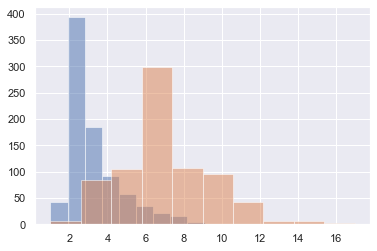

In [31]:
plt.hist(pp_distance, alpha=0.5);
plt.hist(np_distance, alpha=0.5);

## Edge Splitting: Local negative edges

Instead of splitting the edges manually we can use the `EdgeSplitter` class in the StellarGraph library. This class extracts a randomly sampled subset of positive pairs (true links) and a randomly sampled set of negative pairs and returns the reduced graph G_test with the positive test edges removed.

This function can select negative edges in the same way we did previously, using nodes anywhere in the graph, or *locally* where nodes are selected randomly from a distribution over path distances.

To use this class we greate the full graph using all edges:

In [32]:
g_full = nx.from_edgelist(edgelist)

The `EdgeSplitter` randomly samples a fraction `p=0.1` of all edges as positive links, and same number of negative links. The splitter can also ensure the graph remains connected with the `keep_connected=True` argument and samples from the path-length distribution `probs`.

In [33]:
edge_splitter_test = EdgeSplitter(g_full)

g_reduced, all_pairs, all_labels = edge_splitter_test.train_test_split(
    p=0.1, method="local", keep_connected=True, probs=[0.2]*5
)

** Sampled 527 positive and 527 negative edges. **


Notice the shortest path distances between node pairs are now similar:

In [34]:
pp_distance = pair_distance(g_reduced, all_pairs[all_labels==1])
np_distance = pair_distance(g_reduced, all_pairs[all_labels==0])

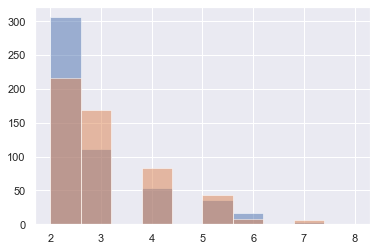

In [35]:
plt.hist(pp_distance, alpha=0.5);
plt.hist(np_distance, alpha=0.5);

In [36]:
train_pairs, test_pairs, train_labels, test_labels = model_selection.train_test_split(
    all_pairs, all_labels, train_size=0.5, random_state=42
)

### Creating the link prediction model

Again we create a StellarGraph object from the NetworkX graph and the node features and targets. This StellarGraph object is required to perform machine learning tasks on the graph.

In [37]:
G = sg.StellarGraph(g_reduced, node_features=node_features)

Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes (paper1, paper2) to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with (paper1, paper2) head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [38]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [39]:
num_samples = [10, 10]

In [40]:
link_generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = link_generator.flow(train_pairs, train_labels)
test_gen = link_generator.flow(test_pairs, test_labels)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated (paper1, paper2) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 16 for both GraphSAGE layers. To help the model generalize we use dropout of 0.3. Note that the length of layer_sizes list must be equal to the length of num_samples.

In [41]:
graphsage = GraphSAGE(
        layer_sizes=[16, 16], generator=train_gen, dropout=0.3
    )

In [42]:
x_inp, x_out = graphsage.link_model()

The link classification layer takes a pair of node embeddings and applies a binary operator to them to produce the corresponding link embedding ('mul' is the elementwise multiplication ; other options for the binary operator can be seen by running a cell with `?link_classification` in it)

In [43]:
h_link = link_classification(
        output_dim=1, output_act="linear", edge_embedding_method='mul'
    )(x_out)

link_classification: using 'mul' method to combine node embeddings into edge embeddings


The classification layer is a Keras dense layer with sigmoid activation:

In [44]:
prediction = keras.layers.Dense(1, activation='sigmoid')(h_link)

Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [45]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )

Evaluate the initial (untrained) model on the train and test set:

In [46]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.6965
	acc: 0.4706

Test Set Metrics of the initial (untrained) model:
	loss: 0.6979
	acc: 0.4782


Now we train the model using the training generator to feed the features for the node pairs:

In [47]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2
    )

Epoch 1/20
 - 6s - loss: 0.6979 - acc: 0.4803 - val_loss: 0.6986 - val_acc: 0.4763
Epoch 2/20
 - 4s - loss: 0.6838 - acc: 0.5786 - val_loss: 0.6991 - val_acc: 0.4744
Epoch 3/20
 - 4s - loss: 0.6738 - acc: 0.6546 - val_loss: 0.6985 - val_acc: 0.4858
Epoch 4/20
 - 4s - loss: 0.6603 - acc: 0.6983 - val_loss: 0.6979 - val_acc: 0.4896
Epoch 5/20
 - 4s - loss: 0.6464 - acc: 0.7720 - val_loss: 0.7008 - val_acc: 0.5009
Epoch 6/20
 - 4s - loss: 0.6310 - acc: 0.7798 - val_loss: 0.7035 - val_acc: 0.4972
Epoch 7/20
 - 4s - loss: 0.6119 - acc: 0.8017 - val_loss: 0.7031 - val_acc: 0.4934
Epoch 8/20
 - 5s - loss: 0.5930 - acc: 0.8425 - val_loss: 0.7045 - val_acc: 0.4858
Epoch 9/20
 - 4s - loss: 0.5702 - acc: 0.8517 - val_loss: 0.7079 - val_acc: 0.5028
Epoch 10/20
 - 4s - loss: 0.5528 - acc: 0.8684 - val_loss: 0.7166 - val_acc: 0.4877
Epoch 11/20
 - 4s - loss: 0.5264 - acc: 0.8906 - val_loss: 0.7191 - val_acc: 0.5142
Epoch 12/20
 - 4s - loss: 0.5076 - acc: 0.8703 - val_loss: 0.7235 - val_acc: 0.5009
E

Plot the training history:

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

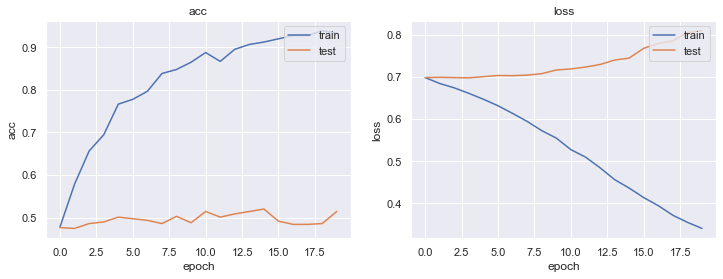

In [49]:
plot_history(history)

Evaluate the trained model on test citation links:

In [50]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.2662
	acc: 0.9715

Test Set Metrics of the trained model:
	loss: 0.8033
	acc: 0.5161


Note that the performance of the link prediction model is considerably lower when local negative pairs are used rather than globally selected negative links. Indeed, given the high train accuracy and close to random test accuracy the model is overfitting to the training dataset and there is no generalization that can be found for local link prediction in this dataset.